# Assignment — Generative Graph Models

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ks_2samp
import random
from zlib import adler32
import requests
from tqdm.notebook import tqdm

### Task 1. Erdos Renyi model (0 point)

Implement Erdos Renyi model (random graph) — each pair of $n$ nodes are connected with some fixed probability $p$.

In [ ]:
def erdos_renyi_graph(n, p):
    G = nx.Graph()
    nodes = np.arange(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(random_edges(nodes, p))
    return G

Write a function `random_edges` with parameters: `nodes` — np.array of nodes, for example [1, 2, 3, 4, ...] and `p` — probability of connection. The function returns np.array with tuples of the form [(1, 2), (2, 4), ...], where 1-2, 2-4 are edges that should be added in the graph.

*Hint: To speed up the generation, look at ALG.1 in the article [Efficient generation of large random networks](http://vlado.fmf.uni-lj.si/pub/networks/doc/ms/rndgen.pdf).*

In [ ]:
def random_edges(nodes, p):
    ### BEGIN SOLUTION
    
    # Option 1: efficient approach
    lp = np.log(1.0 - p)
    edges = []
    n = len(nodes)
    w = -1
    v = 1
    while v < n:
        lr = np.log(1.0 - np.random.random())
        w = w + 1 + int(lr/lp)
        while w >= v and v < n:
            w = w - v
            v = v + 1
        if v < n:
            edges.append((nodes[v-1], nodes[w-1]))
    return np.array(edges)
    
    # Option 2: naive approach
    edges = []
    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):
            n_i, n_j = nodes[i], nodes[j]
            if np.random.random() < p:
                edges.append((nodes[i], nodes[j]))
    return np.array(edges)

    ### END SOLUTION

In [ ]:
'''Check the Erdos-Renyi random graph generation'''
assert len(erdos_renyi_graph(100, 0.1).edges) > 0
n = 100
p = 0.4
n_edges = n * (n-1) / 2
q = 1 - p
sigma = np.sqrt((p * q) / n_edges)
assert  p - 3*sigma < random_edges(np.arange(n), p).shape[0] / n_edges < p + 3*sigma
n = 1000
p = 0.01
n_edges = n * (n-1) / 2
q = 1 - p
sigma = np.sqrt((p * q) / n_edges)
assert  p - 3*sigma < random_edges(np.arange(n), p).shape[0] / n_edges < p + 3*sigma
n = 300
p = 0.9
n_edges = n * (n-1) / 2
q = 1 - p
sigma = np.sqrt((p * q) / n_edges)
assert  p - 3*sigma < random_edges(np.arange(n), p).shape[0] / n_edges < p + 3*sigma

Let us draw a couple of generated graphs

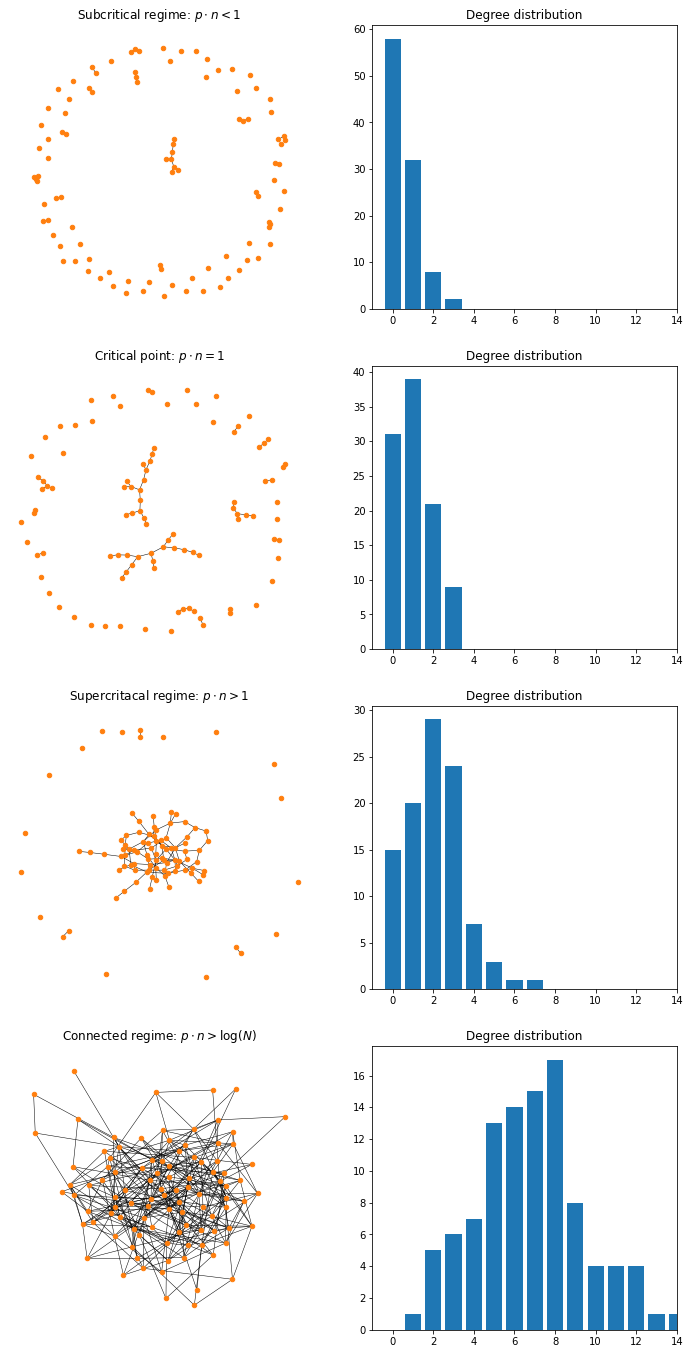

In [ ]:
n = 100
cases = [('Subcritical regime: $p \cdot n < 1$', n, 0.5/n), 
         ('Critical point: $p \cdot n = 1$', n, 1/n), 
         ('Supercritacal regime: $p \cdot n > 1$', n, 2/n), 
         ('Connected regime: $p \cdot n > \log(N)$', n, 6.5/n)]
plt.figure(figsize=(12, 6 * 4))
i = 1
for regime, n, p in cases:
    plt.subplot(4, 2, i)
    G = erdos_renyi_graph(n, p)
    nx.draw(
        G, 
        with_labels=False, 
        node_size=20, 
        width=0.5, 
        node_color='tab:orange')
    plt.title(regime)
    i += 1
    plt.subplot(4, 2, i)
    degree_seq = [degree for (node, degree) in G.degree]
    bins, freq = np.unique(degree_seq, return_counts=True)
    plt.bar(bins, freq)
    plt.xlim((-1, 14))
    plt.title('Degree distribution')
    i += 1

### Task 2. Component sizes in random graphs (0 point)

Let us see how the size of small components (small — not giant) depends on the probability near the critical point: $p =1/n$.

Write a function `small_component_size` with parameters `n` — number of nodes, `probabilities` — np.array of probabilities. The function generates a random graph for each probability and returns np.array of average sizes of small components.

*Hint: to find nodes in components, use `nx.connected_components(graph)`*

In [ ]:
def small_component_size(n, probabilities):
    ### BEGIN SOLUTION
    res = []
    for p in probabilities:
        graph = erdos_renyi_graph(n, p)
        len_cc = list(map(len, sorted(nx.connected_components(graph), key=len)[:-1]))
        res.append(np.mean(len_cc))
    return np.array(res)
    ### END SOLUTION

In [ ]:
n = 1000
p_space = np.linspace(0.01/n, 2.5/n, 50)
sizes = []
for _ in range(5):
    size = small_component_size(n, p_space)
    assert size.shape == (50,)
    sizes.append(size)

av_sizes = np.mean(sizes, axis=0)
assert av_sizes[0] < av_sizes[np.argmin(np.abs(p_space*n - 1))]
assert av_sizes[49] < av_sizes[np.argmin(np.abs(p_space*n - 1))]

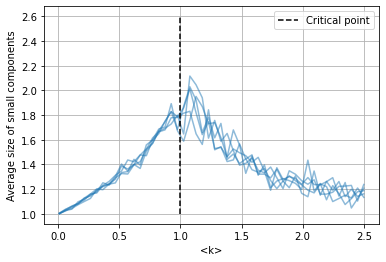

In [ ]:
for i in range(5):
    plt.plot(p_space*n, sizes[i], c='tab:blue', alpha=0.5)
plt.plot([1, 1], [1, 2.6], 'k--', label='Critical point')
plt.xlabel('<k>')
plt.ylabel('Average size of small components')
plt.legend()
plt.grid()
plt.show()

Also let us see how the size of a giant component depends on the probability near the critical point.

Write a function `giant_component_size` with parameters `n` — number of nodes, `probabilities` — np.array of probabilities. The function generates a random graph for each probability and returns np.array of sizes of a giant component.

*Hint: to find nodes in a ginat component, use `max(nx.connected_components(graph), key=len)`*

In [ ]:
def giant_component_size(n, probabilities):
    ### BEGIN SOLUTION
    res = []
    for p in probabilities:
        graph = erdos_renyi_graph(n, p)
        giant_nodes = max(nx.connected_components(graph), key=len)
        res.append(len(giant_nodes))
    return np.array(res)
    ### END SOLUTION

In [ ]:
n = 1000
p_space = np.linspace(0.01/n, 2.5/n, 50)
sizes = []
for _ in range(5):
    size = giant_component_size(n, p_space)
    assert size.shape == (50,)
    sizes.append(size)

av_sizes = np.mean(sizes, axis=0)
assert av_sizes[0] < 20
assert 20 < av_sizes[np.argmin(np.abs(p_space*n - 1))] < 150
assert 700 < av_sizes[np.argmin(np.abs(p_space*n - 2))] < 900

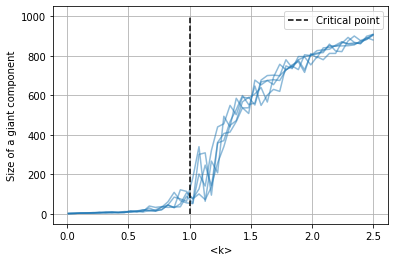

In [ ]:
for i in range(5):
    plt.plot(p_space*n, sizes[i], c='tab:blue', alpha=0.5)
plt.plot([1, 1], [0, 1000], 'k--', label='Critical point')
plt.xlabel('<k>')
plt.ylabel('Size of a giant component')
plt.legend()
plt.grid()
plt.show()

### Task 3. Average path length in random graphs (0 point)

In this task, we consider whether a random network is capable to model the small world phenomenon, also known as six degrees of separation — the distance between two randomly chosen nodes in a network is short. In other words, the average path length between two randomly chosen nodes increases in a growing network, but not so fast as the number of nodes.

Write a function `growing_path_len` with parameters: `av_node_degree` is an average node degree and `n_nodes` is a np.array of numbers of nodes. The function generates a random network for each number of nodes and returns a np.array of average path lengths.

*Hints:*
* *To calculate average path length, use `nx.average_shortest_path_length`*
* *Consider a giant component only*
* *To find nodes in a ginat component, use `max(nx.connected_components(graph), key=len)`*
* *To create a subgraph, use `graph.subgraph(nodes).copy()`*

In [ ]:
def growing_path_len(av_node_degree, n_nodes):
    ### BEGIN SOLUTION
    res = []
    for n in tqdm(n_nodes):
        p = av_node_degree / n
        random_net = erdos_renyi_graph(n, p)
        giant_nodes = max(nx.connected_components(random_net), key=len)
        largest_cc = random_net.subgraph(giant_nodes).copy()
        res.append(nx.average_shortest_path_length(largest_cc))
    return np.array(res)
    ### END SOLUTION

In [ ]:
n_nodes = np.arange(100, 1100, 100)
av_node_degree = 50
lengths = growing_path_len(av_node_degree, n_nodes)

assert lengths.shape == (10,)
assert 1.4 < lengths[0] < 1.6
assert 1.9 < lengths[5] < 1.95
assert 2 < lengths[9] < 2.1

  0%|          | 0/10 [00:00<?, ?it/s]

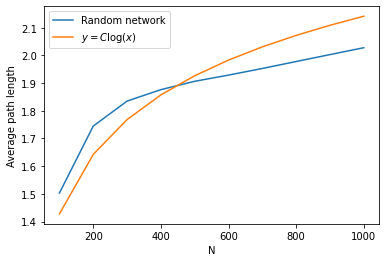

In [ ]:
plt.plot(n_nodes, lengths, label='Random network')
plt.xlabel('N')
plt.ylabel('Average path length')
plt.plot(n_nodes, 0.31 * np.log(n_nodes), label='$y=C\log(x)$')
plt.legend()
plt.show()

As we see, the small world phenomenon holds — the average path length increases at most logarithmically with respect to the number of nodes. Theoretically, the diameter $d_\max$ in a random network is

$$d_\max \approx \frac{\ln N}{\ln \langle k \rangle}$$

that corresponds to some real scale-free networks.

### Task 4. Clustering coefficients of random vs real networks (1.5 points)

Clustering coefficient of a node $C_i$ contains information about relationship between nearest neighbors.  $C_i = 0$ means that there is no links between neighbors and $C_i = 1$ means that there are all possible links between them. Clustering coefficient of an Erdos-Renyi random graph is equal to the probability $p$ and does not dependent of a node and its degree:

$$C_i = \langle C \rangle = \frac{\langle k \rangle}{n} = p $$

Let us check it on generated data.

Write a function `node_degree_clustering` with parameters `n, p` — number of nodes and probability. The function generates Erdos-Renyi random graph and returns a tuple with two np.arrays: degrees and clustering coefficients. Ordering of elements should coincide: the first degree and first clustering coefficient are related to the first node and so on.

*Hint: to calculate clustering coefficients, use `nx.clustering(graph)`*

In [ ]:
def node_degree_clustering(n, p):
    # YOUR CODE HERE
    degree = []
    clustering = []
    graph = erdos_renyi_graph(n, p)
    clusterings = nx.clustering(graph)
    clustering = [item for item in clusterings]
    degrees = graph.degree()
    degree = [x[1] for x in degrees]
    return [np.array(degree), np.array(clustering)]

In [ ]:
p = 0.9
n = 100
degree, clustering = node_degree_clustering(n, p)
assert degree.shape == clustering.shape
assert clustering.mean() - 3*clustering.std() < p < clustering.mean() + 3*clustering.std()
assert degree.mean() - 3*degree.std() < p * n < degree.mean() + 3*degree.std()
p = 0.1
n = 1000
degree, clustering = node_degree_clustering(n, p)
assert degree.shape == clustering.shape
assert clustering.mean() - 3*clustering.std() < p < clustering.mean() + 3*clustering.std()
assert degree.mean() - 3*degree.std() < p * n < degree.mean() + 3*degree.std()
p = 0.01
n = 3000
degree, clustering = node_degree_clustering(n, p)
assert degree.shape == clustering.shape
assert clustering.mean() - 3*clustering.std() < p < clustering.mean() + 3*clustering.std()
assert degree.mean() - 3*degree.std() < p * n < degree.mean() + 3*degree.std()

Let us draw the dependency between node degree and clustering coefficient

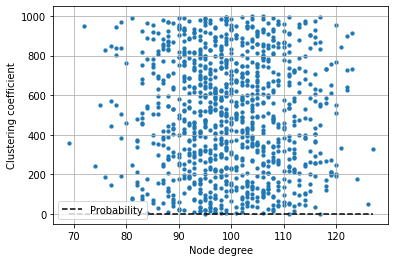

In [ ]:
p = 0.1
n = 1000
degree, clustering = node_degree_clustering(n, p)
plt.scatter(degree, clustering, s=15, linewidths=0.3)
plt.plot([degree.min(), degree.max()], [p, p], 'k--', label='Probability')
plt.xlabel('Node degree')
plt.ylabel('Clustering coefficient')
plt.legend()
plt.grid()
plt.show()

Let us look at the dependency of a some real social network.

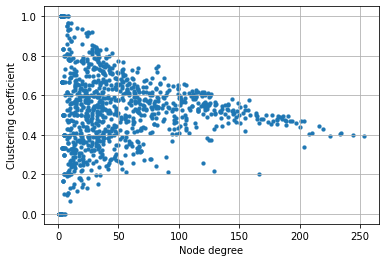

In [ ]:
degree = np.loadtxt(
    'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/real_net_degree.txt'
)
clustering = np.loadtxt(
    'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/real_net_clustering.txt'
)
plt.scatter(degree, clustering, s=15, linewidths=0.3)
plt.xlabel('Node degree')
plt.ylabel('Clustering coefficient')
plt.grid()
plt.show()

We can see that the average clustering coefficient slightly decreases in high degrees.

### Task 5. Snobbish Networks (2 points)

Consider a network of $N$ red and $N$ blue nodes. The probability that there is a link between nodes of identical color is $p$ and the probability that there is a link between nodes of different color is $q$. A network is snobbish if $p>q$, capturing a tendency to connect to nodes of the same color. For $q = 0$ the network has at least two components, containing nodes with the same color.

Write a function `snobbish_network` that takes the number of red (or blue) nodes `n`, probability of link between nodes of the same color `p` and probability of link between nodes of different color `q`. The function returns a network with $2N$ nodes where every node has an attribute `color` that can be `blue` or `red`.

*Hint: to set node attributes, use `nx.set_node_attributes`*

In [ ]:
def snobbish_network(n, p, q):
    # YOUR CODE HERE
    graph = nx.Graph()
    nodes = np.arange(2 * n)
    graph.add_nodes_from(nodes)
    graph.add_edges_from(random_edges(nodes[0 : n - 1], p))
    graph.add_edges_from(random_edges(nodes[n: 2 * n - 1], p))

    edges = []
    for i in range(n):
        for j in range(n, 2 * n):
            if np.random.random() < q:
                edges.append((nodes[i], nodes[j]))
    graph.add_edges_from(np.array(edges))
    blues = {}
    blues = dict.fromkeys(np.arange(n), "blue")
    reds = {}
    reds = dict.fromkeys(range(n, 2 * n), "red")
    blues.update(reds)
    nx.set_node_attributes(graph, blues, name="color")
    return graph

In [ ]:
sn_net = snobbish_network(100, 0.1, 0.01)
assert sn_net.number_of_nodes() == 200
assert set(nx.get_node_attributes(sn_net, 'color').values()) == {'blue', 'red'}
assert np.sum(np.array(list(nx.get_node_attributes(sn_net, 'color').values())) == 'red') == 100
assert 0.76 < nx.attribute_assortativity_coefficient(sn_net, 'color') < 0.88
sn_net = snobbish_network(200, 0.1, 0.05)
assert 0.25 < nx.attribute_assortativity_coefficient(sn_net, 'color') < 0.4

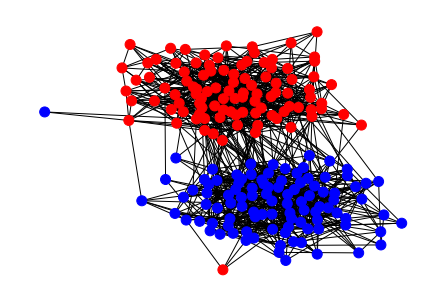

In [ ]:
sn_net = snobbish_network(100, 0.1, 0.01)
nx.draw(sn_net, 
        node_color=nx.get_node_attributes(sn_net, 'color').values(), 
        node_size=100)

### Task 6. Watts-Strogatz model (1.5 point)

Implement Watts-Strogatz model (small-world model) — rewire an edge with probability `p` in a ring lattice with `n` nodes and `k` degree.

In [ ]:
'''Do not touch the cell'''
def watts_strogatz_graph(n, k, p):
    G = ring_lattice(n, k)
    for node in G.nodes:
        rewire(G, node, k, p)
    return G

Write a function `ring_lattice` that returns a regular ring lattice with `n` nodes (0, 1, 2, ..., n-1) and `k` node degree.

In [ ]:
def ring_lattice(n, k):
    # YOUR CODE HERE
    graph = nx.Graph()
    nodes = np.arange(n)
    graph.add_nodes_from(nodes)
    edges = []
    for node in nodes:
      for i in range(node + 1, node + k // 2 + 1):
        edges.append((nodes[node], nodes[i % n]))
    graph.add_edges_from(edges)
    return graph

In [ ]:
assert nx.degree_histogram(ring_lattice(10, 2))[2] == 10
assert nx.degree_histogram(ring_lattice(10, 3))[2] == 10
assert nx.degree_histogram(ring_lattice(10, 4))[4] == 10

Write a function `rewire` that takes in input a ring lattice `G`, a `node`, a model parameter `k` and probability `p`. For every right hand side neighbor $i$, the function rewires an edge (`node`, $i$) into a random edge (`node`, $j$) with probability `p` where $i \neq j \neq $ `node`.

*Hints:*
* *Why do we only rewire right hand side edges? We want to guarantee that only untouched in previous iterations edges will be rewound. Look at the picture — we could not move the red edges in previous iterations.
![](https://raw.githubusercontent.com/netspractice/network-science/main/assignment_generative_network_models/how_to_rewire.png)*
* *To speed up the generation, do not filter nodes to random selection. If a selected node produces an existing edge or a loop, just skip it.*

In [ ]:
def rewire(G, node, k, p):
    # YOUR CODE HERE
    N = G.number_of_nodes()
    neib = list(G.neighbors(node))
    right_neib = []
    for i in neib:
      if i > node:
        right_neib.append(i)
    for j in right_neib:
      if np.random.random() < p:
        h = np.random.choice(N)
        while h == node or G.has_edge(node, h):
          h = np.random.choice(N)
        if h in right_neib:
          continue
        else:
          G.remove_edge(node, j)
          G.add_edge(node, h)

In [ ]:
cases = [[50, 8, 0.1], 
         [1000, 10, 0.01],
         [1000, 10, 0.5],
         [1000, 10, 0.99]]
for n, k, p in cases:
    G = watts_strogatz_graph(n, k, p)
    assert nx.number_of_nodes(G) == n
    assert nx.number_of_edges(G) == int(k / 2 * n)
    degree_seq = [degree for (node, degree) in G.degree]
    nxG = nx.watts_strogatz_graph(n, k, p, 1)
    nxdegree_seq = [degree for (node, degree) in nxG.degree]
    assert ks_2samp(degree_seq, nxdegree_seq).pvalue > 0.05

Let us draw a small-world graph in some steps of the algorithm

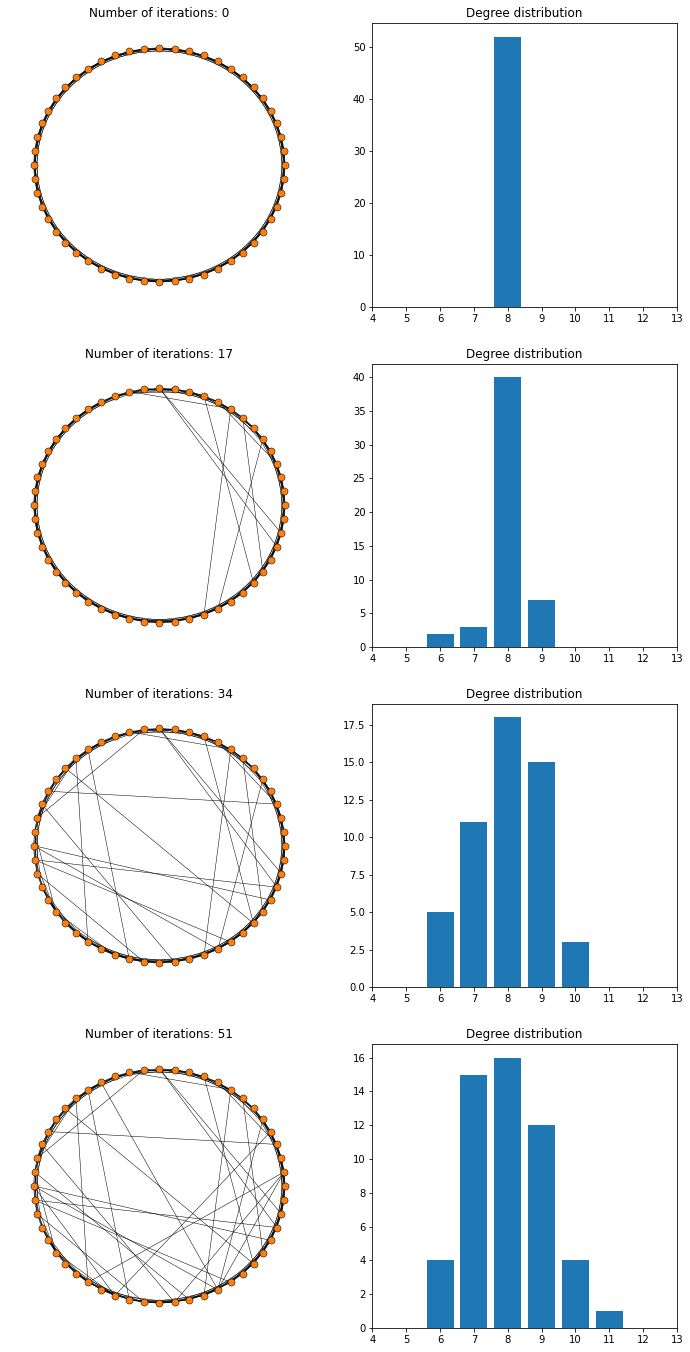

In [ ]:
n, k, p = 52, 8, 0.2
G = ring_lattice(n, k)
plt.figure(figsize=(12, 6 * 4))
i = 1
for node in G.nodes:
    if node in np.arange(0, n+1, int(n/3)):
        plt.subplot(4, 2, i)
        plt.title('Number of iterations: {}'.format(node))
        nx.draw_circular(
            G,
            node_size=50, 
            width=0.5,
            linewidths=0.5,
            edgecolors='black',
            node_color='tab:orange')
        i += 1
        plt.subplot(4, 2, i)
        degree_seq = [degree for (node, degree) in G.degree]
        bins, freq = np.unique(degree_seq, return_counts=True)
        plt.bar(bins, freq)
        plt.xlim((4, 13))
        plt.title('Degree distribution')
        i += 1
    rewire(G, node, k, p)

### Task 7. Average path length in Watts-Strogatz (1.5 point)

Let us check that the average path length tends to theoretical value during building the small-world model.

$$\langle L \rangle = \begin{cases}
N/2k, \text{ if } p \to 0 \\
\log(N)/\log(k), \text{ if } p \to 1
\end{cases}$$

So that we have a lower and upper limits of path lengths for $0 < p < 1$.

Write a function `smallworld_path_len` with Watts-Strogatz model parameters `n, k, p` that returns np.array of average path lengths in each step (node). The length of the array is `n`.

*Hint: to calculate the average shortest path length, use `nx.average_shortest_path_length`*

In [ ]:
def smallworld_path_len(n, k, p):
    # YOUR CODE HERE
    G = ring_lattice(n, k)
    lengths = []
    for node in G.nodes:
        lengths.append(nx.average_shortest_path_length(G))
        rewire(G, node, k, p)

    return np.array(lengths)

In [ ]:
n, k, p = 101, 10, 0.05
lengths = smallworld_path_len(n, k, p)
step_space = np.log(np.arange(1, len(lengths) + 1))
X = np.stack([step_space, np.ones(lengths.shape[0])], axis=1)
assert lengths.shape[0] == n
assert 0.1 < -(np.linalg.pinv(X) @ np.log(lengths))[0] < 0.25

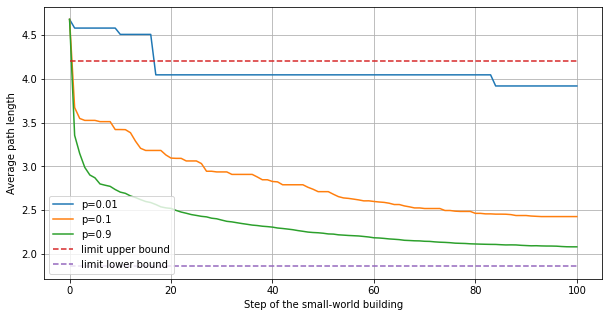

In [ ]:
plt.figure(figsize=(10, 5))

n, k, p = 101, 12, 0.01
lengths = smallworld_path_len(n, k, p)
plt.plot(lengths, label=f'p={p}')

n, k, p = 101, 12, 0.1
lengths = smallworld_path_len(n, k, p)
plt.plot(lengths, label=f'p={p}')

n, k, p = 101, 12, 0.9
lengths = smallworld_path_len(n, k, p)
plt.plot(lengths, label=f'p={p}')

plt.xlabel('Step of the small-world building')
plt.ylabel('Average path length')
plt.grid()
plt.plot([0, 100], [n / 2 / k, n / 2 / k], '--', 
         label='limit upper bound')
plt.plot([0, 100], [np.log(n) / np.log(k), np.log(n) / np.log(k)], '--',
         label='limit lower bound')
plt.legend(loc='lower left')
plt.show()

### Task 8. Barabasi-Albert model (1.5 points)

Implement Barabasi-Albert model (preferential attachment model) – a growth process where each new node connects to `m` existing nodes. The higher node degree, the higher probability of the connection. The final number of nodes is `n`.

You start from a star graph with `m + 1` nodes. In each step you create `m` edges between a new node and existing nodes. The probability of connection to the node $i$ is 
$$p(i) = \frac{k_i}{\sum k}$$

Write a function `attach` that attaches a `node` to a graph `G` through `m` edges.

*Hint: Create a list with repeated nodes from a list of edges. For example, $[(1, 2), (2, 3), (2, 4)] \to [1, 2, 2, 3, 2, 4]$. Uniformly select nodes one-by-one. Apply `random.choice` instead of `np.random.choice` to speed up the generation.*

In [ ]:
'''Do not touch the cell'''
def barabasi_albert_graph(n, m, random_seed=1):
    G = nx.star_graph(m)
    for i in range(1, n - m):
        attach(m + i, G, m)
    return G

In [ ]:
def attach(node, G, m):
    # YOUR CODE HERE
    prob_list = []
    for e in G.edges:
      prob_list.append(e[0])
      prob_list.append(e[1])
    G.add_node(node)
    for i in range(m):
      rand_node = random.choice(prob_list)
      G.add_edge(node, rand_node)
      prob_list = [x for x in prob_list if x != rand_node]

In [ ]:
G = nx.star_graph(3)
attach(4, G, 3)
assert nx.number_of_edges(G) == 6

cases = [[10, 3], 
         [1000, 3], 
         [1000, 20]]
for n, m in cases:
    G = barabasi_albert_graph(n, m)
    degree_seq = [degree for (node, degree) in G.degree]
    nxG = nx.barabasi_albert_graph(n, m)
    nxdegree_seq = [degree for (node, degree) in nxG.degree]
    assert ks_2samp(degree_seq, nxdegree_seq).pvalue > 0.05

Let us see what the growth process looks like

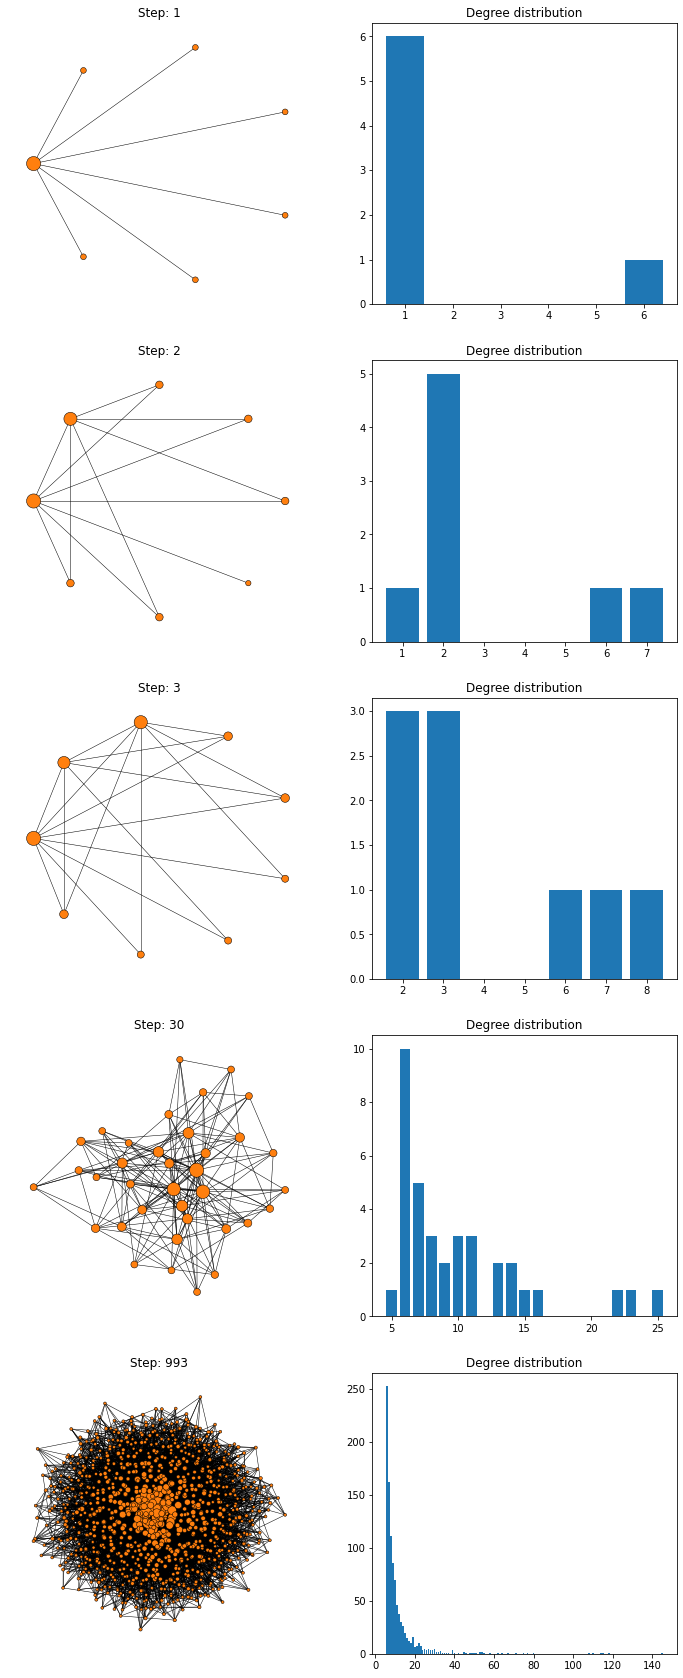

In [ ]:
n, m = 1000, 6
G = nx.star_graph(m)
plt.figure(figsize=(12, 6 * 5))
j = 1
for i in range(1, n - m):
    if i in [1, 2, 3, 30, n-m-1]:
        plt.subplot(5, 2, j)
        j += 1
        sizes = np.array(list(nx.degree_centrality(G).values()))
        sizes = sizes / max(sizes) * 200
        if i <= 3:
            pos = nx.layout.shell_layout(G)
        else:
            pos = nx.layout.spring_layout(G)
        nx.draw(
            G,
            pos=pos,
            with_labels=False, 
            node_size=sizes, 
            width=0.5,
            linewidths=0.5,
            edgecolors='black',
            node_color='tab:orange')
        plt.title('Step: {}'.format(i))
        degree_seq = [degree for (node, degree) in G.degree]
        bins, freq = np.unique(degree_seq, return_counts=True)
        plt.subplot(5, 2, j)
        j += 1
        plt.bar(bins, freq)
        plt.title('Degree distribution')
    attach(m + i, G, m)

### Task 9. Degree distribution in Barabasi-Albert model (0 point)

Barabasi-Albert graph has a degree distribution of the form

$$P(k) = \frac{2m^2}{k^3}$$

That is Power law with $\alpha = 3$ and $k_\min = m$. 

Check this fact by an experiment — generate a set of Barabasi-Albert graphs and estimate parameters of Power law using MLE. 

First, write a function `power_law_cdf` that takes an argument and parameters of the Power law distribution and returns the CDF.

In [ ]:
def power_law_cdf(k, alpha=3.5, k_min=1):
    ### BEGIN SOLUTION
    return 1 - (k / k_min) ** (1 - alpha)
    ### END SOLUTION

In [ ]:
assert power_law_cdf(2, 2, 1) == 0.5
assert power_law_cdf(10, 2, 1) == 0.9

Next, write a function `mle_power_law_params` that takes a degree sequence and returns a tuple: the best $\alpha$, the best $k_\min$.

In [ ]:
def mle_power_law_params(degree_sequence):
    ### BEGIN SOLUTION
    from scipy.stats import kstest
    best_alpha, best_x_min = None, None
    min_ks_dist = np.inf
    for x_min in np.arange(degree_sequence.min(), degree_sequence.max()):
        x = degree_sequence[degree_sequence >= x_min]
        alpha = 1 + len(x) / np.log(x / x_min).sum()
        ks_dist = kstest(x, power_law_cdf, args=(alpha, x_min)).statistic
        if ks_dist < min_ks_dist:
            min_ks_dist, best_alpha, best_x_min = ks_dist, alpha, x_min
    return best_alpha, best_x_min
    ### END SOLUTION

In [ ]:
assert mle_power_law_params(np.array([1, 2, 3]))[0] > 0
assert mle_power_law_params(np.array([1, 2, 3]))[1] > 0

Write a function `estimate_power_law` that generates Barabasi-Albert graphs with `n` nodes, from `m_min` to `m_max` connections and returns a tuple of np.arrays: $\alpha$ and $k_{\min}$ for each graph.

In [ ]:
def estimate_power_law(n, m_min, m_max):
    ### BEGIN SOLUTION
    alpha_space = []
    k_min_space = []
    for m in np.arange(m_min, m_max + 1):
        G = nx.barabasi_albert_graph(n, m)
        degree_seq = np.array([degree for (node, degree) in G.degree])
        alpha, k_min = mle_power_law_params(degree_seq)
        alpha_space.append(alpha)
        k_min_space.append(k_min)
    return np.array(alpha_space), np.array(k_min_space)
    ### END SOLUTION

In [ ]:
'''Check the Power law parameters'''
n, m_min, m_max = 500, 2, 20
alpha, k_min = estimate_power_law(n, m_min, m_max)
assert alpha.shape[0] == m_max - m_min + 1
assert 2 < alpha.mean() < 4
assert k_min[0] < k_min[-1]

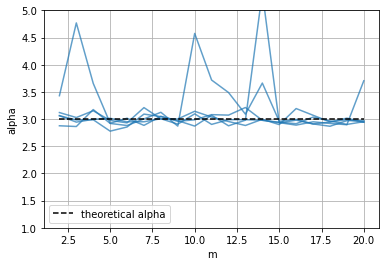

In [ ]:
n, m_min, m_max = 500, 2, 20
m_space = np.arange(m_min, m_max + 1)
for _ in range(5):
    alpha, k_min = estimate_power_law(n, m_min, m_max)
    plt.plot(m_space, alpha, alpha=0.7, c='tab:blue')
plt.plot([2, 20], [3, 3], 'k--', label='theoretical alpha')
plt.ylim((1, 5))
plt.xlabel('m')
plt.ylabel('alpha')
plt.grid()
plt.legend()
plt.show()

### Task 10. Degree dynamics in Barabasi-Albert model (2 points)

Measure the degree dynamics in Barabasi-Albert model of one of the initial nodes and of the nodes added to the network at intermediate time moments (steps of the algorithm).

Write a function `generate_degree_dynamics` that takes np.array with considered nodes, generates Barabasi-Albert graph ($n=3000$, $m=6$) and returns a np.array of the shape `(29, len(nodes))` — degrees of these nodes at time moments 100, 200, 300, ..., 3000. If the node does not exist yet, pass `np.nan` value.

*Hint: use the `barabasi_albert_graph` function as a template*

In [ ]:
def generate_degree_dynamics(cons_nodes):
    # YOUR CODE HERE
    n = 3000
    m = 6
    degrees = []
    G = nx.star_graph(m)
    for i in range(1, n - m):
        attach(m + i, G, m)
        if i % 100 == 0:
          for j in cons_nodes:
            if j > i:
              degrees.append(np.nan)
            else:
              degrees.append(G.degree[j])

    return np.array(degrees).reshape(29, len(cons_nodes))

In [ ]:
degree_dynamics = generate_degree_dynamics([0, 100, 700, 2000])
assert degree_dynamics.shape == (29, 4)
assert np.all(np.isnan(degree_dynamics[0]) == [False, False,  True,  True])
assert np.all(np.isnan(degree_dynamics[9]) == [False, False,  False,  True])
assert degree_dynamics[0, 0] < degree_dynamics[-1, 0]
assert degree_dynamics[0, 1] < degree_dynamics[-1, 1]
assert degree_dynamics[-1, 0] > degree_dynamics[-1, 3]

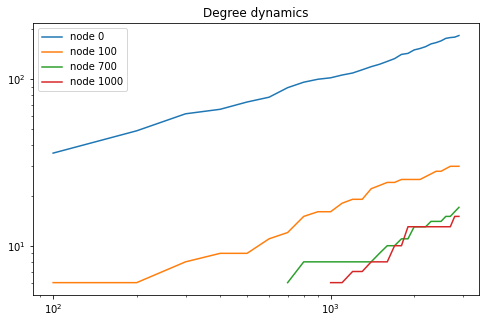

In [ ]:
degree_dynamics = generate_degree_dynamics([0, 100, 700, 1000])
plt.figure(figsize=(8, 5))
time_space = np.tile(np.arange(100, 3000, 100), (4, 1)).T
plt.plot(time_space, degree_dynamics)
plt.legend(['node 0', 'node 100', 'node 700', 'node 1000'])
plt.title('Degree dynamics')
plt.xscale('log')
plt.yscale('log')
plt.show()